In [ ]:
# Python 3.6.10
# Pytorch 1.4.0

In [28]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%autosave 180

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Autosaving every 180 seconds


In [29]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.io
import scipy.io as spio
import torch
import torch.nn as nn
import scipy.interpolate
import torch.optim as optim

In [30]:
# codes taken from https://stackoverflow.com/questions/7008608/scipy-io-loadmat-nested-structures-i-e-dictionaries

def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    def _check_keys(d):
        '''
        checks if entries in dictionary are mat-objects. If yes
        todict is called to change them to nested dictionaries
        '''
        for key in d:
            if isinstance(d[key], spio.matlab.mio5_params.mat_struct):
                d[key] = _todict(d[key])
            elif isinstance(d[key], np.ndarray):
                d[key] = _tolist(d[key])
        return d

    def _todict(matobj):
        '''
        A recursive function which constructs from matobjects nested dictionaries
        '''
        d = {}
        for strg in matobj._fieldnames:
            elem = matobj.__dict__[strg]
            if isinstance(elem, spio.matlab.mio5_params.mat_struct):
                d[strg] = _todict(elem)
            elif isinstance(elem, np.ndarray):
                d[strg] = _tolist(elem)
            else:
                d[strg] = elem
        return d

    def _tolist(ndarray):
        '''
        A recursive function which constructs lists from cellarrays
        (which are loaded as numpy ndarrays), recursing into the elements
        if they contain matobjects.
        '''
        elem_list = []
        for sub_elem in ndarray:
            if isinstance(sub_elem, spio.matlab.mio5_params.mat_struct):
                elem_list.append(_todict(sub_elem))
            elif isinstance(sub_elem, np.ndarray):
                elem_list.append(_tolist(sub_elem))
            else:
                elem_list.append(sub_elem)
        return elem_list
    data = scipy.io.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

In [31]:
#model
def f1(v,g):
    if v>0:
        return 1-g
    else:
        return g
def f2(v,w1,w2):
    if v>0:
        return w1
    else:
        return w2

class Model(torch.nn.Module):
    def __init__(self,dt,feedback=True):
        super(Model, self).__init__()
        self.tv = nn.Parameter(torch.tensor(0.0125))
        self.ty = nn.Parameter(torch.tensor(0.1434))
        self.w = nn.Parameter(torch.tensor(6.9436))
        self.g1 = nn.Parameter(torch.tensor(0.01)) 
        self.input_scalar1 = nn.Parameter(torch.tensor(7.6689))
        self.input_scalar2 = nn.Parameter(torch.tensor(3.7096))
        self.dt = dt
        self.y0 = torch.tensor(0.0)
        self.outputbias = nn.Parameter(torch.tensor(0.6032))
        self.outputweights = nn.Parameter(torch.tensor(0.7355))
        self.feedback=feedback

    def forward(self, sti_y, target):
        res_list=[]
        res_list.append(-target[0])
        v= -target[0]
        y= self.y0 if self.feedback else 0
        for i in range(1,len(sti_y)):
            if self.feedback:
                sti=sti_y[i]*f2(sti_y[i],self.input_scalar1,self.input_scalar2)
                dy=(-y+v*f1(v,torch.clamp(self.g1,0,1)))/self.ty*self.dt
                dv=(-v-self.w*y-sti)/self.tv*self.dt
                v=v+dv
                y=y+dy
            else:
                sti=sti_y[i]*f2(sti_y[i],self.input_scalar1,self.input_scalar2)
                dy=(-y+v*f1(v,torch.clamp(self.g1,0,1)))/self.ty*self.dt
                dv=(-v-self.w*y-sti)/self.tv*self.dt
                v=v+dv
                y=0
            res_list.append(self.outputweights*(v+self.outputbias))
        res_list=torch.stack(res_list)
        return -res_list

In [42]:
#Choose whether to fit L1 or L2
selection='L1'
assert selection in ['L1' and 'L2']

In [43]:
res=loadmat(f'data/{selection}_highLum.mat')
mean_res,t=np.array(res['meanResp']),np.array(natsti_res['t'])
res2=loadmat(f'data/{selection}_lowLum.mat')
mean_res2,t2=np.array(res2['meanResp']),np.array(natsti_res2['t'])

In [44]:
#data preprocessing
mean_sub=np.concatenate([mean_res[0],mean_res[1]]).mean()
std_div=np.concatenate([mean_res[0],mean_res[1]]).std()
mean_res1=mean_res[1]
mean_res1=(mean_res1-mean_sub)/std_div
mean_res2=mean_res[0]
mean_res2=(mean_res2-mean_sub)/std_div
#create stimulus
sti_t=t
sti_y1=np.zeros(len(t))
sti_y1[2:5]=1
sti_t=t
sti_y2=np.zeros(len(t))
sti_y2[2:5]=-1
#
dt=(t[-1]-t[0])/(len(t)-1)

In [52]:
torch.manual_seed(0)
model=Model(dt)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)
if selection=='L2':
    model.tv.data.fill_(0.02)
    model.ty.data.fill_(0.3)
    model.w.data.fill_(4.0)
    model.g1.data.fill_(0.35)
    model.input_scalar1.data.fill_(3.0)
    model.input_scalar2.data.fill_(2.0)
    model.outputbias.data.fill_(0.16)
    model.outputweights.data.fill_(1.8)

In [53]:
#model training
for i in range(5000):
    if i==3000:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.2*param_group['lr']
    optimizer.zero_grad()
    loss=0
    pred=model(sti_y1,torch.from_numpy(mean_res1))
    loss+=criterion(pred,torch.from_numpy(mean_res1))
    pred=model(sti_y2,torch.from_numpy(mean_res2))
    loss+=criterion(pred,torch.from_numpy(mean_res2))
    loss.backward()
    optimizer.step()

In [54]:
fitted_w=model.w.item()
print(list(model.named_parameters()))

[('tv', Parameter containing:
tensor(0.0131, requires_grad=True)), ('ty', Parameter containing:
tensor(0.5613, requires_grad=True)), ('w', Parameter containing:
tensor(12.7118, requires_grad=True)), ('g1', Parameter containing:
tensor(0.1686, requires_grad=True)), ('input_scalar1', Parameter containing:
tensor(5.6441, requires_grad=True)), ('input_scalar2', Parameter containing:
tensor(3.4075, requires_grad=True)), ('outputbias', Parameter containing:
tensor(0.2574, requires_grad=True)), ('outputweights', Parameter containing:
tensor(1.0586, requires_grad=True))]


Text(0, 0.5, 'a. u.')

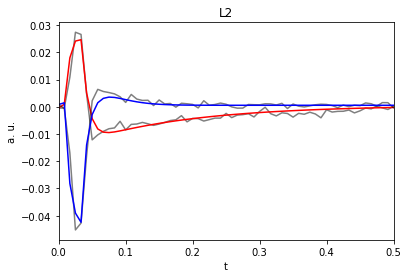

In [55]:
#make predictions
pred2=model(sti_y2,torch.from_numpy(mean_res2))
pred1=model(sti_y1,torch.from_numpy(mean_res1))
plt.plot(t[:],-(mean_res2[:]*std_div+mean_sub),alpha=.5,label='Data',c='k')
plt.plot(t,-(pred2.detach().cpu().numpy()*std_div+mean_sub),label='Model',c='r')
plt.plot(t[:],-(mean_res1[:]*std_div+mean_sub),alpha=.5,label='Data',c='k')
plt.plot(t,-(pred1.detach().cpu().numpy()*std_div+mean_sub),label='Model',c='blue')
plt.xlim(0,0.5)
plt.title(selection)
plt.xlabel('t')
plt.ylabel('a. u.')

In [56]:
#change w and g for plots in Fig. 3 and S3
t_delay=21
cleansignal1=np.zeros(1024)
tvec=np.linspace(0,0.8,1024)
cleansignal1[200:800]=-1
cleansignal1[800:]=0.5
cleansignal=np.zeros(1024)
tvec=np.linspace(0,0.8,1024)
cleansignal[200+t_delay:800+t_delay]=-1
cleansignal[800+t_delay:]=0.5
expwindow=np.exp(-np.arange(0,3.02,0.02))
expwindow=expwindow[::-1]
expwindow=expwindow/expwindow.sum()
inpvec=cleansignal1
blurinput1=np.zeros(len(inpvec))
for ii in range(len(expwindow),len(inpvec)):
    blurinput1[ii]=np.sum(inpvec[ii-len(expwindow):ii]*expwindow)
expwindow=np.exp(-np.arange(0,3.02,0.02))
expwindow=expwindow[::-1]
expwindow=expwindow/expwindow.sum()
inpvec=cleansignal
blurinput=np.zeros(len(inpvec))
for ii in range(len(expwindow),len(inpvec)):
    blurinput[ii]=np.sum(inpvec[ii-len(expwindow):ii]*expwindow)
model.dt=tvec[1]-tvec[0]
model.w.data.fill_(0)
model.outputbias.data.fill_(0)
model.outputweights.data.fill_(1)
model.input_scalar1.data.fill_(1)
model.input_scalar2.data.fill_(1)

tensor(1.)

([<matplotlib.axis.YTick at 0x7f9690168080>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

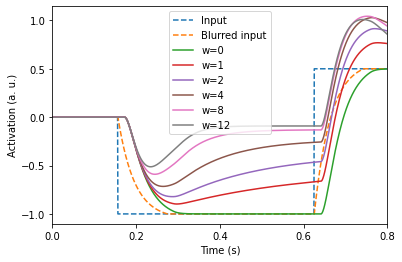

In [57]:
plt.plot(tvec,cleansignal1,linestyle='--',label='Input')
plt.plot(tvec,blurinput1,linestyle='--',label='Blurred input')
for w in [0,1,2,4,8,12]:
    model.w.data.fill_(w)
    plt.plot(tvec,model(torch.from_numpy(blurinput),torch.from_numpy(blurinput)).detach().numpy(),label='w=%s'%str(w))
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Activation (a. u.)')
plt.xlim(0,0.8)
plt.xticks([0,0.2,0.4,0.6,0.8])
plt.yticks([-1,-0.5,0,0.5,1])

([<matplotlib.axis.YTick at 0x7f968bdc8f60>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

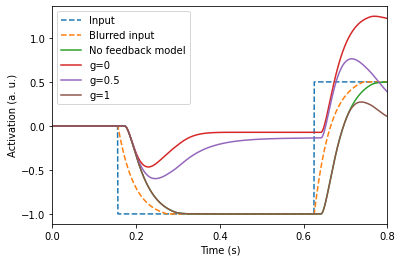

In [58]:
plt.plot(tvec,cleansignal1,linestyle='--',label='Input')
plt.plot(tvec,blurinput1,linestyle='--',label='Blurred input')
model.w.data.fill_(0)
plt.plot(tvec,model(torch.from_numpy(blurinput),torch.from_numpy(blurinput)).detach().numpy(),label='No feedback model')
model.w.data.fill_(fitted_w)
for g in [0,0.5,1]:
    model.g1.data.fill_(g)
    plt.plot(tvec,model(torch.from_numpy(blurinput),torch.from_numpy(blurinput)).detach().numpy(),label='g=%s'%str(g))
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Activation (a. u.)')
plt.xlim(0,0.8)
plt.xticks([0,0.2,0.4,0.6,0.8])
plt.yticks([-1,-0.5,0,0.5,1])

([<matplotlib.axis.YTick at 0x7f968bd5fd30>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

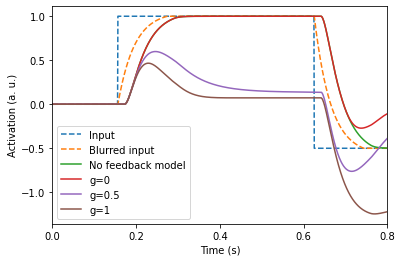

In [59]:
t_delay=21
cleansignal1=np.zeros(1024)
tvec=np.linspace(0,0.8,1024)
cleansignal1[200:800]=1
cleansignal1[800:]=-0.5
cleansignal=np.zeros(1024)
tvec=np.linspace(0,0.8,1024)
cleansignal[200+t_delay:800+t_delay]=1
cleansignal[800+t_delay:]=-0.5
expwindow=np.exp(-np.arange(0,3.02,0.02))
expwindow=expwindow[::-1]
expwindow=expwindow/expwindow.sum()
inpvec=cleansignal1
blurinput1=np.zeros(len(inpvec))
for ii in range(len(expwindow),len(inpvec)):
    blurinput1[ii]=np.sum(inpvec[ii-len(expwindow):ii]*expwindow)
expwindow=np.exp(-np.arange(0,3.02,0.02))
expwindow=expwindow[::-1]
expwindow=expwindow/expwindow.sum()
inpvec=cleansignal
blurinput=np.zeros(len(inpvec))
for ii in range(len(expwindow),len(inpvec)):
    blurinput[ii]=np.sum(inpvec[ii-len(expwindow):ii]*expwindow)
plt.plot(tvec,cleansignal1,linestyle='--',label='Input')
plt.plot(tvec,blurinput1,linestyle='--',label='Blurred input')
model.w.data.fill_(0)
plt.plot(tvec,model(torch.from_numpy(blurinput),torch.from_numpy(blurinput)).detach().numpy(),label='No feedback model')
model.w.data.fill_(fitted_w)
for g in [0,0.5,1]:
    model.g1.data.fill_(g)
    plt.plot(tvec,model(torch.from_numpy(blurinput),torch.from_numpy(blurinput)).detach().numpy(),label='g=%s'%str(g))
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Activation (a. u.)')
plt.xlim(0,0.8)
plt.xticks([0,0.2,0.4,0.6,0.8])
plt.yticks([-1,-0.5,0,0.5,1])